In [1]:
import pandas as pd
org_df = pd.read_csv("/kaggle/input/ghouls-goblins-and-ghosts-boo/train.csv.zip")

df = org_df
y_df = df[['type']]
df = df.drop(labels=['type'],axis=1)
x_df = df

t_df = pd.read_csv("/kaggle/input/ghouls-goblins-and-ghosts-boo/test.csv.zip")
df.shape,t_df.shape
df = df.drop(labels=['id'],axis=1)

In [2]:
df.sample(2)

,bone_length,rotting_flesh,hair_length,has_soul,color
83,0.485802,0.571908,0.656528,0.465085,black
122,0.572494,0.516335,0.463063,0.291004,white


# **Checking for empty values**

<AxesSubplot:>

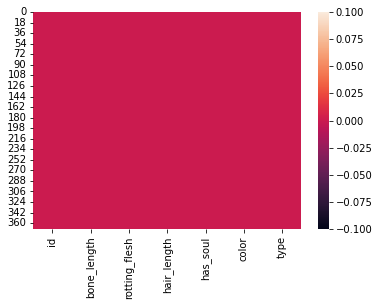

In [3]:
import seaborn as sns

sns.heatmap(org_df.isna())

# **Checking creatures types distribution**

<AxesSubplot:>

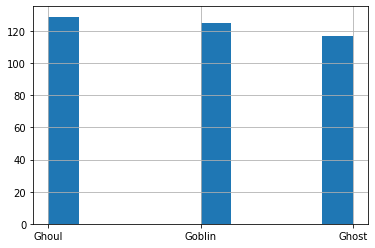

In [4]:
y_df['type'].hist()

# **Scatter Plot**

In [5]:
import plotly.express as px

px.scatter(org_df,x='type',y='bone_length',color='type')

In [6]:
px.scatter(org_df,x='hair_length',y='has_soul',color='type')

In [7]:
px.scatter(org_df,x='bone_length',y='has_soul',color='type')

<AxesSubplot:>

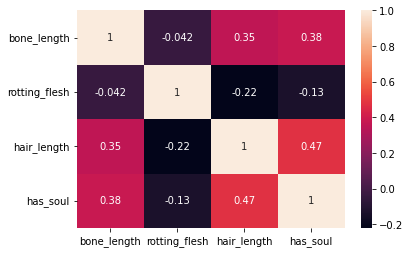

In [8]:
sns.heatmap(df.corr(),annot=True)

# **Creating pipelines to facilitate pre-processing**

Such as: Scalling, Imputing, Encoding etc

In [9]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.compose import ColumnTransformer
import numpy as np
num_columns = df.select_dtypes(exclude=['object']).columns
cat_columns = df.select_dtypes(include=['object']).columns
cat_pipe = Pipeline([
    ('one_hot_encoder',OneHotEncoder(handle_unknown='ignore',sparse=False)),
])

num_pipe = Pipeline([
        ('standard_scaler',StandardScaler())
])


pre_process = ColumnTransformer([('categorical',cat_pipe,cat_columns),('numerical',num_pipe,num_columns)])
x_train,x_test,y_train,y_test = train_test_split(x_df,y_df,random_state=777)

x_train.shape,y_train.shape,x_test.shape,y_test.shape

((278, 6), (278, 1), (93, 6), (93, 1))

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

svc = make_pipeline(pre_process,SVC())
mlp = make_pipeline(pre_process,MLPClassifier())
rf = make_pipeline(pre_process,RandomForestClassifier())
knn = make_pipeline(pre_process,KNeighborsClassifier())
dtree = make_pipeline(pre_process,DecisionTreeClassifier())




In [11]:
svc,mlp,rf,knn,dtree

(Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('categorical',
                                                   Pipeline(steps=[('one_hot_encoder',
                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                  sparse=False))]),
                                                   Index(['color'], dtype='object')),
                                                  ('numerical',
                                                   Pipeline(steps=[('standard_scaler',
                                                                    StandardScaler())]),
                                                   Index(['bone_length', 'rotting_flesh', 'hair_length', 'has_soul'], dtype='object'))])),
                 ('svc', SVC())]),
 Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('categorica

# Tuning NeuralNetwork parameters

In [12]:
params = {'mlpclassifier__hidden_layer_sizes':[(5,5),(5,),(5,5,5)],
          'mlpclassifier__activation':['logistic','relu','tanh'],
          'mlpclassifier__solver':['sgd','lbfgs','adam'],'mlpclassifier__verbose':[0],'mlpclassifier__max_iter':[10000]}
mlp_grid = GridSearchCV(estimator=mlp,param_grid=params,n_jobs=-1)
mlp_grid.fit(x_train,y_train.values.ravel())

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('one_hot_encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         Index(['color'], dtype='object')),
                                                                        ('numerical',
                                                                         Pipeline(steps=[('standard_scaler',
                                                                                          StandardScaler())]),
                                                                         Inde

In [13]:
mlp_grid.best_score_

0.7482467532467532

# Tuning RandomForestClassifier parameters

In [14]:
param_grid = { 
    'randomforestclassifier__n_estimators': [200, 500],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_depth' : [4,5,6,7,8],
    'randomforestclassifier__criterion' :['gini', 'entropy']
}
rf_grid = GridSearchCV(estimator=rf,param_grid=param_grid,n_jobs=-1)
rf_grid.fit(x_train,y_train.values.ravel())
rf_grid.best_score_

0.7267532467532467

In [15]:
rf_grid.best_score_

0.7267532467532467

# Tuning KNN Parameters

In [16]:
param_grid = {'kneighborsclassifier__n_neighbors': [5, 25], 'kneighborsclassifier__weights': ['uniform', 'distance']}
knn_grid = GridSearchCV(estimator=knn,param_grid=param_grid,n_jobs=-1)
knn_grid.fit(x_train,y_train.values.ravel())
knn_grid.best_score_

0.7087662337662339

# Tuning SVC Parameters

In [17]:
param_grid = {'svc__C':[1,10,100,1000],'svc__gamma':[1,0.1,0.001,0.0001], 'svc__kernel':['linear','rbf']}
svc_grid = GridSearchCV(estimator=svc,param_grid=param_grid,n_jobs=-1)
svc_grid.fit(x_train,y_train.values.ravel())
svc_grid.best_score_

0.759025974025974

# Visualizing a Confusion Matrix for all the models

/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier



0.6881720430107527

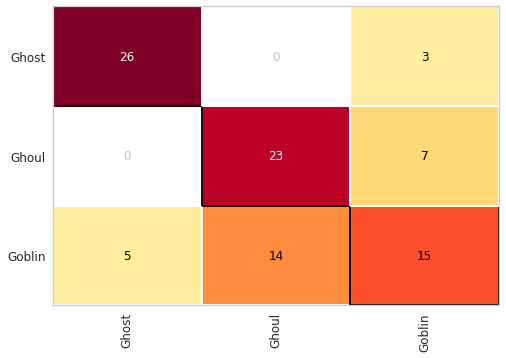

In [18]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(mlp_grid)
cm.score(x_test,y_test)

/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier



0.7419354838709677

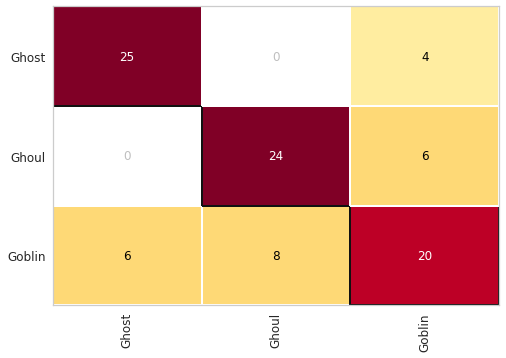

In [19]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(svc_grid)
cm.score(x_test,y_test)

/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier



0.6774193548387096

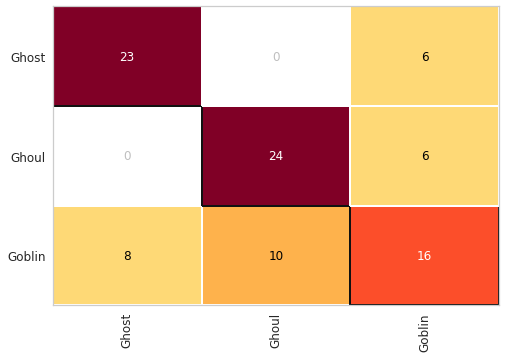

In [20]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(rf_grid)
cm.score(x_test,y_test)

/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier



0.7096774193548387

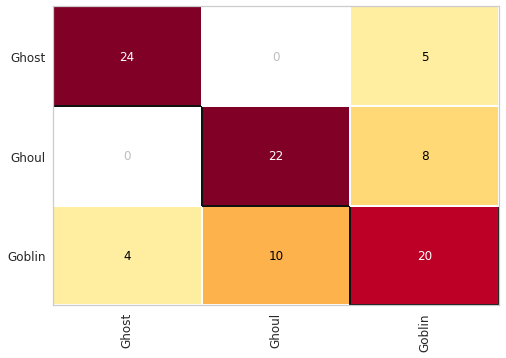

In [21]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(knn_grid)
cm.score(x_test,y_test)

# Checking the classification_report with the 2 best models

In [22]:
from sklearn.metrics import classification_report
y_pred = svc_grid.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       Ghost       0.81      0.86      0.83        29
       Ghoul       0.75      0.80      0.77        30
      Goblin       0.67      0.59      0.62        34

    accuracy                           0.74        93
   macro avg       0.74      0.75      0.74        93
weighted avg       0.74      0.74      0.74        93



In [23]:
from sklearn.metrics import classification_report
y_pred = mlp_grid.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       Ghost       0.84      0.90      0.87        29
       Ghoul       0.62      0.77      0.69        30
      Goblin       0.60      0.44      0.51        34

    accuracy                           0.69        93
   macro avg       0.69      0.70      0.69        93
weighted avg       0.68      0.69      0.68        93

